__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import os  # OS operations (read/write files/folders)

# process parallelization
from multiprocessing import Lock, Manager, Pool, cpu_count

import matplotlib.pyplot as plt  # mother of plots focr Python
import pandas as pd  # operate with dataframes
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.2f}".format

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Helper functions__

In [3]:
def pbar_fork_hack(l=None):
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    if l:
        global lock
        lock = l
    print(" ", end="", flush=True)

__Read participants cleaned data__

In [4]:
parts = pd.read_csv("../participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,questionnaire,nulls_%
id,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,No,6.74
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,No,0.22
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,No,46.24
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,No,8.05
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,No,26.88
...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,No,34.18
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,No,7.41
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,No,7.15


In [5]:
files_worse = os.listdir("../data/raw/CsvData_worse")

for f in files_worse:  # iterate over files
    # remove hidden/config files and folders
    if not f.endswith(".csv"):
        files_worse.remove(f)

uids_worse = list(set([f.split("-")[2].split(".")[0] for f in files_worse]))
len(uids_worse)

95

In [6]:
parts = parts.loc[uids_worse]
parts.index.size

95

In [7]:
def get_perc_valid(uid):
    """Description."""
    sel = parts.loc[uid]
    file = f"Path_ MS Wissenschaft-{sel.condition}-{uid}.csv"
    worse = pd.read_csv(f"../data/raw/CsvData_worse/{file}")
    total = worse.index.size
    val_worse = worse[pd.isnull(worse.hitObjectNames)].index.size
    val_worse_p = val_worse * 100 / total
    res[uid]["%nullWorseOld"] = sel["nulls_%"]
    res[uid]["%nullWorse"] = val_worse_p


manager = Manager()  # manage shared memory types

# convert into memory-shared dict of lists for multiprocessing
res = manager.dict(
    {
        uid: manager.dict({"%nullWorseOld": None, "%nullWorse": None})
        for uid in uids_worse
    }
)

# multiprocessing lock to avoid raicing conditions
l = Lock()

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# test participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap(func=get_perc_valid, iterable=uids_worse),
    total=len(uids_worse),
    desc="📂 worse participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 95 📂 worse participants processed:                                                                     …

In [8]:
test = dict(res)

test = {k: dict(v) for k, v in res.items()}

test = pd.DataFrame(test)
test = test.transpose()

In [9]:
test

,%nullWorseOld,%nullWorse
6aef7feed2dd42cca4265715cc2464eb,51.03,30.29
bfbf1b340a254f2ea3d062e281fda330,54.14,43.88
b96944c2608547fb8140a3bf77676d1f,53.61,52.38
e70f20b3956748fab589e4c3015f1ed5,50.84,37.21
d2a3860415634b408e0714b835ef301f,55.67,44.59
...,...,...
63bd71ddcccb45b5b539fbc53b1e9e4e,52.79,30.55
1eab0b87e162459fb6e86324c28106b0,52.12,50.73
4a14708c40c34276ba9b6c150c8a69ef,50.43,36.80
4388678182784d01a430421ffee98f8c,52.23,39.65


In [10]:
test["%valWorseOld"] = 100 - test["%nullWorseOld"]
test["%valWorse"] = 100 - test["%nullWorse"]
test

,%nullWorseOld,%nullWorse,%valWorseOld,%valWorse
6aef7feed2dd42cca4265715cc2464eb,51.03,30.29,48.97,69.71
bfbf1b340a254f2ea3d062e281fda330,54.14,43.88,45.86,56.12
b96944c2608547fb8140a3bf77676d1f,53.61,52.38,46.39,47.62
e70f20b3956748fab589e4c3015f1ed5,50.84,37.21,49.16,62.79
d2a3860415634b408e0714b835ef301f,55.67,44.59,44.33,55.41
...,...,...,...,...
63bd71ddcccb45b5b539fbc53b1e9e4e,52.79,30.55,47.21,69.45
1eab0b87e162459fb6e86324c28106b0,52.12,50.73,47.88,49.27
4a14708c40c34276ba9b6c150c8a69ef,50.43,36.80,49.57,63.20
4388678182784d01a430421ffee98f8c,52.23,39.65,47.77,60.35


In [12]:
test.describe()

,%nullWorseOld,%nullWorse,%valWorseOld,%valWorse
count,95.00,95.00,95.00,95.00
mean,53.71,45.03,46.29,54.97
std,3.27,8.54,3.27,8.54
min,50.09,25.42,33.96,34.74
25%,51.48,38.52,44.95,48.91
50%,52.60,45.00,47.40,55.00
75%,55.05,51.09,48.52,61.48
max,66.04,65.26,49.91,74.58


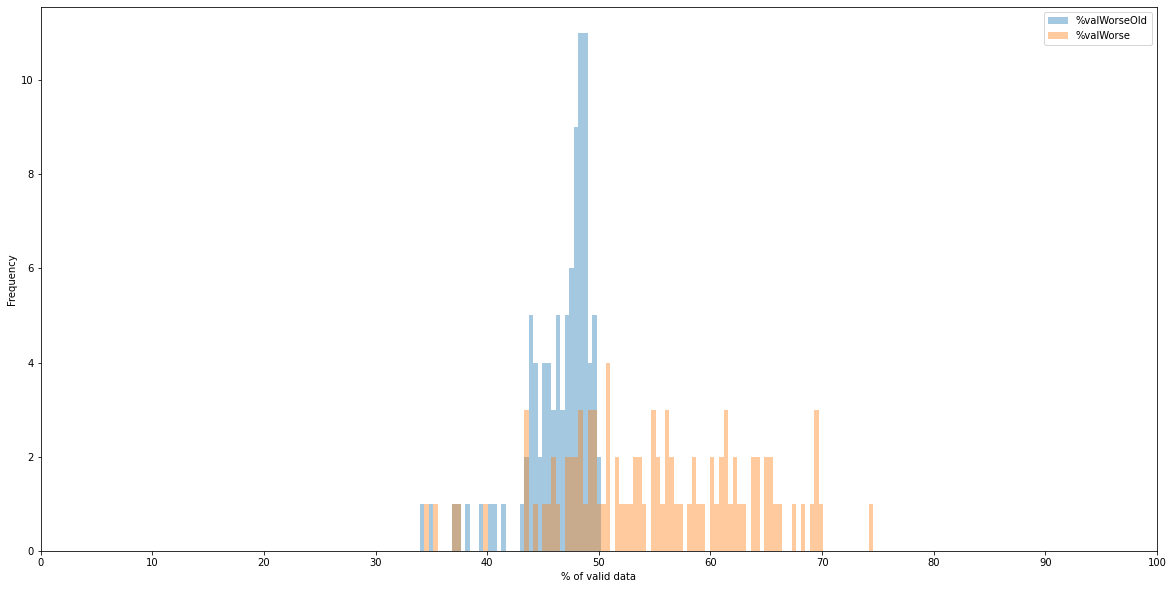

In [11]:
ax = test[["%valWorseOld", "%valWorse"]].plot.hist(
    figsize=(20, 10), alpha=0.4, bins=100
)
ax.set_xticks([i * 10 for i in range(0, 11)])
ax.set_xlabel("% of valid data")
plt.show()